<a href="https://colab.research.google.com/github/ankit-singh973/Deep_Learning/blob/main/Molecular_property_prediction_using_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Coding GNN for Molecular Property Prediction

* Google Colab
* RDKit
* PyTorch Geometric (PyG)

## **Data generated from nuclear receptor signaling and stress pathway assays run against Tox21's 10,000-compound library (Tox21 10K) to build models and look for structure-activity relationships.**

In [10]:
!pip install rdkit-pypi

In [11]:
import torch
pyg_url = f"https://data.pyg.org/whl/torch-{torch.__version__}.html"
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f $pyg_url


Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html


In [12]:
import sys
import urllib.request
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx  #for working with complex networks and graphs
from tqdm.notebook import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx


In [13]:
!curl -O https://raw.githubusercontent.com/itakigawa/mpl_rdkit_utils/main/mpl_rdkit_utils.py

from mpl_rdkit_utils import DrawMolToMPL #draw a RDKit molecule on a Matplotlib plot

# to generate visual representation of molecular graph
def plot_mol_graph(graph, figsize=(8, 4), edge_label=True):
  g = to_networkx(graph, to_undirected=True)             # converts the input graph (graph) into a NetworkX graph (g) in an undirected form.
  edge_dict = defaultdict(list)

# processes the edges of the input graph and populates edge_dict with edge pairs and their associated indices.
 # It also prepares labels for the edges based on these indices.
  for i, e in enumerate(zip(*graph.edge_index.tolist())):
    u, v = e
    edge_dict[(u, v)].append(i)
    edge_dict[(v, u)].append(i)
  labels = {e: "{},{}".format(*edge_dict[e]) for e in g.edges}

  mol = graph.mol #  extracts the RDKit molecule
  AllChem.Compute2DCoords(mol) # computes 2D coordinates for the atoms
  pos = mol.GetConformers()[0].GetPositions()[:,:2] # extract 2D positions of atoms in the conformer molecule

  fig, ax = plt.subplots(1, 2, figsize=figsize) #Plot RDKit molecule
  node_size=300
  nx.draw_networkx(g, pos, ax=ax[0], node_color='#eee', \
                   node_size=node_size, edgecolors='k') #plot networkx graph
  if edge_label:
    nx.draw_networkx_edge_labels(g, pos, ax=ax[0], edge_labels=labels,\
                                font_color='blue', rotate=False)
  dpi = plt.rcParams["figure.dpi"]
  node_radius = (node_size / 3.14159265359)**0.5 / dpi
  ax[0].set_axis_off()
  ax[0].set_aspect('equal')
  xmin, xmax = ax[0].get_xlim()
  ymin, ymax = ax[0].get_ylim()
  fs = min(*figsize)
  xr = node_radius * fs
  yr = node_radius * fs
  ax[0].set_xlim(xmin-xr, xmax+xr)
  ax[0].set_ylim(ymin-yr, ymax+yr)

  (xmin, xmax), (ymin, ymax) = DrawMolToMPL(mol, fig, ax[1])
  ax[1].set_xlim(xmin, xmax)
  ax[1].set_ylim(ymin, ymax)
  ax[1].get_xaxis().set_visible(False)
  ax[1].get_yaxis().set_visible(False)
  plt.tight_layout()
  plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7540  100  7540    0     0  21446      0 --:--:-- --:--:-- --:--:-- 21420


## **Data loading**

In [14]:
infile_name = './input.smi'
key = "nr-arsmiles"
url = "https://tripod.nih.gov/tox21/challenge/download?id={}".format(key)
urllib.request.urlretrieve(url, infile_name)

df = pd.read_csv(infile_name, delim_whitespace=True, header=None)
df.columns = ['smiles', 'id', 'response']
df.to_csv('input.csv')

In [15]:
df

,smiles,id,response
0,CC(O)=O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N...,NCGC00167516-01,0
1,Cl.CCCCCCOC1=CC=C(C(=N)N(CCCC)CCCC)C2=C1C=CC=C2,NCGC00181091-01,0
2,Cl.Cl.COCC(=O)O[C@]3(CCN(C)CCCC1=NC2=C(N1)C=CC...,NCGC00094089-01,0
3,Cl.Cl.CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N...,NCGC00094996-01,0
4,[Br-].CCCCCCCCCCCC[N+](C)(C)CCOC1=CC=CC=C1,NCGC00257773-01,0
...,...,...,...
9357,CCCC1=CC(=O)NC(=S)N1,NCGC00259290-01,0
9358,S=C1NCCN1,NCGC00258846-01,0
9359,S=C1NCCN1,NCGC00254936-01,0
9360,CCOP(=S)(OCC)OC1=CC=C(C=C1)[N+]([O-])=O,NCGC00254571-01,0


In [16]:
df = pd.read_csv('input.csv', index_col=0)
smi = df['smiles'][1]
mol = Chem.MolFromSmiles(smi)

In [17]:
smi

'Cl.CCCCCCOC1=CC=C(C(=N)N(CCCC)CCCC)C2=C1C=CC=C2'

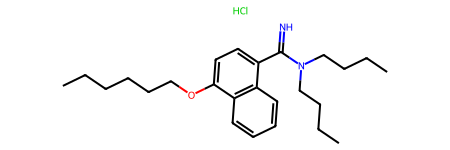

In [18]:
mol

In [19]:
df.shape

(9362, 3)

# molecular graphs for pyg

In [20]:
edges = []
for bond in mol.GetBonds():  # iterates through all the bonds in the RDKit molecule `mol`
  i = bond.GetBeginAtomIdx() #returns the index of the atom at the beginning of the bond.
  j = bond.GetEndAtomIdx()
  edges.extend([(i,j), (j,i)])

In [21]:
edge_index = list(zip(*edges))

In [22]:
edge_index

[(1,
  2,
  2,
  3,
  3,
  4,
  4,
  5,
  5,
  6,
  6,
  7,
  7,
  8,
  8,
  9,
  9,
  10,
  10,
  11,
  11,
  12,
  12,
  13,
  12,
  14,
  14,
  15,
  15,
  16,
  16,
  17,
  17,
  18,
  14,
  19,
  19,
  20,
  20,
  21,
  21,
  22,
  11,
  23,
  23,
  24,
  24,
  25,
  25,
  26,
  26,
  27,
  27,
  28,
  24,
  8,
  28,
  23),
 (2,
  1,
  3,
  2,
  4,
  3,
  5,
  4,
  6,
  5,
  7,
  6,
  8,
  7,
  9,
  8,
  10,
  9,
  11,
  10,
  12,
  11,
  13,
  12,
  14,
  12,
  15,
  14,
  16,
  15,
  17,
  16,
  18,
  17,
  19,
  14,
  20,
  19,
  21,
  20,
  22,
  21,
  23,
  11,
  24,
  23,
  25,
  24,
  26,
  25,
  27,
  26,
  28,
  27,
  8,
  24,
  23,
  28)]

In [23]:
def atom_feature(atom):
  return [atom.GetAtomicNum(), # return atomic number
          atom.GetDegree(), #number of bonds
          atom.GetNumImplicitHs(), #h-bonds associated
          atom.GetIsAromatic()]

def bond_feature(bond):
  return [bond.GetBondType(),
          bond.GetStereo()] #

In [24]:
node_features = [atom_feature(a) for a in mol.GetAtoms()]
edge_features = [bond_feature(b) for b in mol.GetBonds()]

In [25]:
g = Data(edge_index=torch.LongTensor(edge_index),
         x=torch.FloatTensor(node_features),
         edge_attr=torch.FloatTensor(edge_features),
         smiles=smi,
         mol=mol)

In [26]:
g

Data(x=[29, 4], edge_index=[2, 58], edge_attr=[29, 2], smiles='Cl.CCCCCCOC1=CC=C(C(=N)N(CCCC)CCCC)C2=C1C=CC=C2', mol=<rdkit.Chem.rdchem.Mol object at 0x7a1265f6b450>)

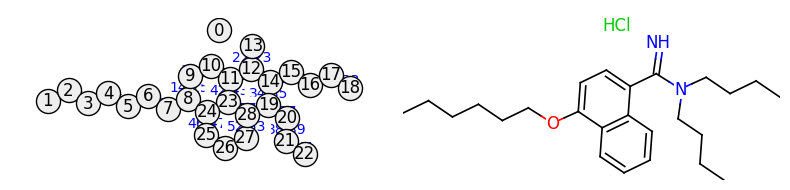

In [27]:
plot_mol_graph(g)

In [28]:
# converts a SMILES representation of a molecule into a PyTorch Geometric
def smi_to_pyg(smi, y):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
      return None
#  extracts pairs of atom indices from the molecular structure
    id_pairs = ((b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol.GetBonds())

# convert pairs of atom indices into a list of tuples, where each tuple represents a bidirectional (undirected) edge between two atoms
    atom_pairs = [z for (i, j) in id_pairs for z in ((i, j), (j, i))]

    bonds = (mol.GetBondBetweenAtoms(i, j) for (i, j) in atom_pairs)

# collects features for each atom in the molecule by calling the atom_feature
# include properties like atomic number, degree, number of implicit hydrogens, and aromaticity
    atom_features = [atom_feature(a) for a in mol.GetAtoms()]

#  include the bond type and stereochemistry
    bond_features = [bond_feature(b) for b in bonds]

# constructs a PyTorch Geometric Data object representing the molecule's graph structure and associated information.
    return Data(edge_index=torch.LongTensor(list(zip(*atom_pairs))), # containing the edge connections between atoms
                x=torch.FloatTensor(atom_features),
                edge_attr=torch.FloatTensor(bond_features),
                y=torch.LongTensor([y]),
                mol=mol, #  The RDKit molecule object
                smiles=smi) #  original SMILES representation of the molecule

In [29]:
class MyDataset(Dataset):
  def __init__(self, smiles, response):
    mols = [smi_to_pyg(smi, y) for smi, y in \
            tqdm(zip(smiles, response), total=len(smiles))]
    self.X = [m for m in mols if m]

  def __getitem__(self, idx):
    return self.X[idx]  # retrieve a data point at a specific index

  def __len__(self):
    return len(self.X)

In [30]:
base_dataset = MyDataset(df['smiles'], df['response'])

  0%|          | 0/9362 [00:00<?, ?it/s]

[10:06:03] Explicit valence for atom # 3 Si, 8, is greater than permitted
[10:06:04] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[10:06:06] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[10:06:06] WARNING: not removing hydrogen atom without neighbors
[10:06:08] Explicit valence for atom # 3 Si, 8, is greater than permitted


In [31]:
base_dataset

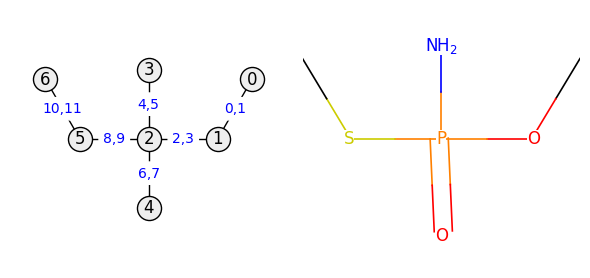

In [32]:
g = base_dataset[8824]
plot_mol_graph(g, figsize=(6, 3), edge_label=True)

In [33]:
g

Data(x=[7, 4], edge_index=[2, 12], edge_attr=[12, 2], y=[1], mol=<rdkit.Chem.rdchem.Mol object at 0x7a126381eff0>, smiles='COP(N)(=O)SC')

In [34]:
# node (atom) features of a graph g
g.x

tensor([[ 6.,  1.,  3.,  0.],
        [ 8.,  2.,  0.,  0.],
        [15.,  4.,  0.,  0.],
        [ 7.,  1.,  2.,  0.],
        [ 8.,  1.,  0.,  0.],
        [16.,  2.,  0.,  0.],
        [ 6.,  1.,  3.,  0.]])

In [35]:
# represents the edge (bond) features of a graph
g.edge_attr

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [2., 0.],
        [2., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

-  row corresponds to an edge (bond) in the graph, and each column represents a feature of that edge

In [36]:
g.edge_index

tensor([[0, 1, 1, 2, 2, 3, 2, 4, 2, 5, 5, 6],
        [1, 0, 2, 1, 3, 2, 4, 2, 5, 2, 6, 5]])

# train/val/test split

In [37]:
# stratified random split of the dataset.
# each part of the split contains an equal percentage of the data

N = len(base_dataset)
M = N // 10

indices = np.random.permutation(range(N))

idx = {'train': indices[:8*M],  # 8 parts
      'valid': indices[8*M:9*M], # 1 part
      'test': indices[9*M:]} # 1 part

modes = ['train', 'valid', 'test']

In [38]:
dataset = {m: Subset(base_dataset, idx[m]) for m in modes}
loader = {m: DataLoader(dataset[m], batch_size=200, shuffle=True) if m == 'train' \
          else DataLoader(dataset[m], batch_size=200) for m in modes}

# ecfp4 + random_forest

In [39]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score

In [40]:
# def ECFP4(mol):
#   return np.asarray(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))

In [41]:
# X = {m: np.vstack([ECFP4(data.mol) for data in dataset[m]]) for m in modes}
# y = {m: np.asarray([data.y.numpy() for data in dataset[m]]).flatten() for m in modes}

In [42]:
# model = RandomForestClassifier()
# model.fit(X['train'], y['train'])

In [43]:
# for m in ['valid', 'test']:
#   y_pred = model.predict(X[m])
#   for metric in [accuracy_score, balanced_accuracy_score, roc_auc_score]:
#     print("{} {} {:.3f}".format(m, metric.__name__, metric(y[m], y_pred)))

# attentive_fp

In [45]:
from torch_geometric.nn.models import AttentiveFP

In [46]:
node_dim = base_dataset[0].num_node_features
edge_dim = base_dataset[0].num_edge_features
node_dim, edge_dim

(4, 2)

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [48]:
model = AttentiveFP(out_channels=2, # active or inactive
                    in_channels=node_dim, edge_dim=edge_dim,
                    hidden_channels=200, num_layers=3, num_timesteps=2,
                    dropout=0.2)
model = model.to(device)

In [49]:
train_epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, \
                                                steps_per_epoch=len(loader['train']),
                                                epochs=train_epochs)
criterion = nn.CrossEntropyLoss()

In [50]:
def train(loader):
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        total_examples += data.num_graphs
    return total_loss / total_examples

@torch.no_grad()
def test(loader):
    total_loss = total_examples = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss.item()
        total_examples += data.num_graphs
    return total_loss / total_examples

@torch.no_grad()
def predict(loader):
    y_pred = []
    y_true = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        _, predicted = torch.max(out.data, 1)
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred


In [1]:
best_val = float("inf")

learn_curve = defaultdict(list)
func = {'train': train, 'valid': test, 'test': test}

for epoch in tqdm(range(1, train_epochs+1)):
    loss = {}
    for mode in ['train', 'valid', 'test']:
      loss[mode] = func[mode](loader[mode])
      learn_curve[mode].append(loss[mode])
    if loss['valid'] < best_val:
      torch.save(model.state_dict(), 'best_val.model')
    if epoch % 20 == 0:
      print(f'Epoch: {epoch:03d} Loss: ' + ' '.join(
          ['{} {:.6f}'.format(m, loss[m]) for m in modes]
      ))

NameError: ignored

In [ ]:
fig, ax = plt.subplots()
for m in modes:
  ax.plot(learn_curve[m], label=m)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_yscale('log')
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_val.model'))

for m in ['valid', 'test']:
  y_true, y_pred = predict(loader[m])
  for metric in [accuracy_score, balanced_accuracy_score, roc_auc_score]:
    print("{} {} {:.3f}".format(m, metric.__name__, metric(y_true, y_pred)))

# gin & gatv2 with edge_attr

In [ ]:
from torch_geometric.nn import GINEConv, GATv2Conv, global_add_pool

In [ ]:
def MyConv(node_dim, edge_dim, arch='GIN'):
  conv = None
  if arch == 'GIN':
    h = nn.Sequential(nn.Linear(node_dim, node_dim, bias=True))
    conv = GINEConv(h, edge_dim=edge_dim)
  elif arch == 'GAT':
    conv = GATv2Conv(node_dim, node_dim, edge_dim=edge_dim)
  return conv

In [ ]:
class MyGNN(nn.Module):
  def __init__(self, node_dim, edge_dim, arch, num_layers=3):
    super().__init__()
    layers = [MyConv(node_dim, edge_dim, arch) for _ in range(num_layers)]
    self.convs = nn.ModuleList(layers)

  def forward(self, x, edge_index, edge_attr):
    for conv in self.convs:
      x = conv(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
    return x

In [ ]:
[int(x) for x in Chem.rdchem.BondType.names.values()]

In [ ]:
ptable = Chem.GetPeriodicTable()
for i in range(200):
  try:
    s = ptable.GetElementSymbol(i)
  except:
    print(f'max id {i-1} for {s}')
    break
ptable.GetElementSymbol(i-1)

In [ ]:
class MyFinalNetwork(nn.Module):
  def __init__(self, node_dim, edge_dim, arch, num_layers=3,
               encoding='onehot'):
    super().__init__()

    self.encoding = encoding
    if encoding != 'onehot':
      self.atom_encoder = nn.Embedding(num_embeddings=118+1, embedding_dim=64)
      self.bond_encoder = nn.Embedding(num_embeddings=21+1, embedding_dim=8)
      node_dim = (node_dim-1) + 64
      edge_dim = (edge_dim-1) + 8
    else:
      node_dim = (node_dim-1) + 118+1
      edge_dim = (edge_dim-1) + 21+1

    self.gnn = MyGNN(node_dim, edge_dim, arch, num_layers=num_layers)
    embed_dim = int(node_dim / 2)
    self.head = nn.Sequential(
        nn.BatchNorm1d(node_dim),
        nn.Dropout(p=0.5),
        nn.Linear(node_dim, embed_dim, bias=True),
        nn.ReLU(),
        nn.BatchNorm1d(embed_dim),
        nn.Dropout(p=0.5),
        nn.Linear(embed_dim, 2)
    )
  def forward(self, x, edge_index, edge_attr, batch):
    if self.encoding == 'onehot':
      x0 = F.one_hot(x[:, 0].to(torch.int64), num_classes=118+1)
      edge_attr0 = F.one_hot(edge_attr[:, 0].to(torch.int64), num_classes=21+1)
    else:
      x0 = self.atom_encoder(x[:, 0].int())
      edge_attr0 = self.bond_encoder(edge_attr[:, 0].int())

    x = torch.cat([x0, x[:, 1:]], dim=1)
    edge_attr = torch.cat([edge_attr0, edge_attr[:, 1:]], dim=1)

    node_out = self.gnn(x, edge_index, edge_attr)
    graph_out = global_add_pool(node_out, batch)
    return self.head(graph_out)

In [ ]:
model = MyFinalNetwork(node_dim, edge_dim, arch='GAT', num_layers=3, encoding='embedding')
model = model.to(device)

In [ ]:
train_epochs = 200
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, \
                                                steps_per_epoch=len(loader['train']),
                                                epochs=train_epochs)
criterion = nn.CrossEntropyLoss()

In [ ]:
best_val = float("inf")

learn_curve = defaultdict(list)
func = {'train': train, 'valid': test, 'test': test}

for epoch in tqdm(range(1, train_epochs+1)):
    loss = {}
    for mode in ['train', 'valid', 'test']:
      loss[mode] = func[mode](loader[mode])
      learn_curve[mode].append(loss[mode])
    if loss['valid'] < best_val:
      torch.save(model.state_dict(), 'best_val.model')
    if epoch % 20 == 0:
      print(f'Epoch: {epoch:03d} Loss: ' + ' '.join(
          ['{} {:.6f}'.format(m, loss[m]) for m in modes]
      ))

In [ ]:
fig, ax = plt.subplots()
for m in modes:
  ax.plot(learn_curve[m], label=m)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_yscale('log')
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_val.model'))

for m in ['valid', 'test']:
  y_true, y_pred = predict(loader[m])
  for metric in [accuracy_score, balanced_accuracy_score, roc_auc_score]:
    print("{} {} {:.3f}".format(m, metric.__name__, metric(y_true, y_pred)))